In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import nltk
nltk.download('punkt')
nltk.download('wordnet')
from nltk.corpus import stopwords

# Download the stop words from NLTK
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
import pandas as pd
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

def remove_stop_words(text):
    stop_words = set(stopwords.words('english'))
    word_tokens = word_tokenize(text)
    filtered_text = ' '.join([word for word in word_tokens if word.lower() not in stop_words])
    return filtered_text
df = pd.read_csv("/content/drive/MyDrive/train.csv")
df = df.sample(frac=1).reset_index(drop=True)
df = df[0:5000]
for x in range(len(df['Recipe'])):
    if type(df['Recipe'][x]) != str:
        df['Recipe'][x] = ''
df2 = pd.read_csv("/content/drive/MyDrive/dev.csv")
for x in range(len(df2['Recipe'])):
    if type(df2['Recipe'][x]) != str:
        df2['Recipe'][x] = ''
# Apply the function to the DataFrame columns
df['Ingredients'] = df['Ingredients'].apply(remove_stop_words)
df['Recipe'] = df['Recipe'].apply(remove_stop_words)
df2['Ingredients'] = df2['Ingredients'].apply(remove_stop_words)
df2['Recipe'] = df2['Recipe'].apply(remove_stop_words)

In [ ]:
import pandas as pd
import re
import unicodedata
import random
import torch


file_path = ""

# MAX_LENGTH = df['Ingredients'].str.len().max()
MAX_LENGTH = 150
print("Maximum length of strings in 'Ingredients' column:", MAX_LENGTH)
with open("eng-fra.txt", "w") as file:
    for index, row in df.iterrows():
        file.write(f"{row['Recipe']}:::{row['Ingredients']}\n")

SOS_token = 0
EOS_token = 1
UNK_token = 2

class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "SOS", 1: "EOS", 2: "UNK"}
        self.n_words = 3  # Count SOS, EOS, and UNK

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

def normalizeString(s):
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)
    return s

def readLangs(lang1, lang2, reverse=False):
    print("Reading lines...")

    # Read the file and split into lines
    file_name = file_path + 'eng-fra.txt'
    lines = open(file_name, encoding='utf-8').\
        read().strip().split('\n')

    # Split every line into pairs and normalize
    pairs = [[normalizeString(s) for s in l.split(':::')] for l in lines]

    # Reverse pairs, make Lang instances
    if reverse:
        pairs = [list(reversed(p)) for p in pairs]
        input_lang = Lang(lang2)
        output_lang = Lang(lang1)
    else:
        input_lang = Lang(lang1)
        output_lang = Lang(lang2)

    return input_lang, output_lang, pairs

def filterPair(p):
    return len(p[0].split(' ')) < MAX_LENGTH and \
        len(p[1].split(' ')) < MAX_LENGTH

def filterPairs(pairs):
    return [pair for pair in pairs if filterPair(pair)]

def prepareData(lang1, lang2, reverse=False):
    input_lang, output_lang, pairs = readLangs(lang1, lang2, reverse)
    print("Read %s sentence pairs" % len(pairs))
    pairs = filterPairs(pairs)
    print("Trimmed to %s sentence pairs" % len(pairs))
    print("Counting words...")
    for pair in pairs:
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])
    print("Counted words:")
    print(input_lang.name, input_lang.n_words)
    print(output_lang.name, output_lang.n_words)
    return input_lang, output_lang, pairs

input_lang, output_lang, pairs = prepareData('eng', 'fra', True)
print(random.choice(pairs))

def indexesFromSentence(lang, sentence):
    return [lang.word2index.get(word, UNK_token) for word in sentence.split(' ')]

def tensorFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(-1, 1)

def tensorsFromPair(pair):
    input_tensor = tensorFromSentence(input_lang, pair[0])
    target_tensor = tensorFromSentence(output_lang, pair[1])
    return (input_tensor, target_tensor)

with open("eng-fra2.txt", "w") as file:
    for index, row in df2.iterrows():
        file.write(f"{row['Recipe']}:::{row['Ingredients']}\n")

def readLangs(lang1, lang2, reverse=False):
    print("Reading lines...")

    # Read the file and split into lines
    file_name = file_path + 'eng-fra2.txt'
    lines = open(file_name, encoding='utf-8').\
        read().strip().split('\n')

    # Split every line into pairs and normalize
    pairs = [[normalizeString(s) for s in l.split(':::')] for l in lines]

    # Reverse pairs, make Lang instances
    if reverse:
        pairs = [list(reversed(p)) for p in pairs]
        input_lang = Lang(lang2)
        output_lang = Lang(lang1)
    else:
        input_lang = Lang(lang1)
        output_lang = Lang(lang2)

    return input_lang, output_lang, pairs

dev_input_lang, dev_output_lang, dev_pairs = prepareData('eng', 'fra', True)
print(random.choice(dev_pairs))


Maximum length of strings in 'Ingredients' column: 150
Reading lines...
Read 5000 sentence pairs
Trimmed to 4760 sentence pairs
Counting words...
Counted words:
fra 4367
eng 8199
[' c margarine butter md onion chopped lg green pepper chopped garlic clove minced pk diced pimientos oz ts salt ts pepper cn rotel diced tomatoes green chilies oz lb shrimp shelled deveined cooked rice', 'large skillet melt margarine saute onion pepper garlic tender . simmer minutes . add shrimp cook done minutes stirring occasionally . serve cooked rice .']
Reading lines...
Read 797 sentence pairs
Trimmed to 764 sentence pairs
Counting words...
Counted words:
fra 1891
eng 3506
['makes tb sweet butter tb active dry yeast ea eggs separated c warm milk c heavy cream c sugar ts grated lemon rind c white flour preferably ts mace unbleached ts salt ea egg yolk mixed tbsp cream plum apricot raspberry jam', 'make sponge small bowl dissolving yeast warm milk stirring tablespoons sugar flour . let sit covered minutes 

In [ ]:
from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import string
import re
import random

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
import torch
import torch.nn as nn

class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(input_size, hidden_size)
        self.lstm = nn.LSTM(hidden_size, hidden_size)

    def forward(self, input, hidden):
        embedded = self.embedding(input).view(1, 1, -1)
        output = embedded
        output, hidden = self.lstm(output, hidden)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device), torch.zeros(1, 1, self.hidden_size, device=device)

In [ ]:
class DecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size):
        super(DecoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(output_size, hidden_size)
        self.lstm = nn.LSTM(hidden_size, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        output = self.embedding(input).view(1, 1, -1)
        output = F.relu(output)
        output, hidden = self.lstm(output, hidden)
        output = self.softmax(self.out(output[0]))
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device), torch.zeros(1, 1, self.hidden_size, device=device)

In [ ]:
teacher_forcing_ratio = 1
def train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, max_length=MAX_LENGTH):
    encoder_hidden = encoder.initHidden()

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)

    encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

    loss = 0

    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(
            input_tensor[ei], encoder_hidden)
        encoder_outputs[ei] = encoder_output[0, 0]

    decoder_input = torch.tensor([[SOS_token]], device=device)

    decoder_hidden = encoder_hidden

    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

    if use_teacher_forcing:
        # Teacher forcing: Feed the target as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden = decoder(
                decoder_input, decoder_hidden)
            loss += criterion(decoder_output, target_tensor[di])
            decoder_input = target_tensor[di]  # Teacher forcing

    else:
        # Without teacher forcing: use its own predictions as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden = decoder(
                decoder_input, decoder_hidden)
            topv, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze().detach()  # detach from history as input

            loss += criterion(decoder_output, target_tensor[di])
            if decoder_input.item() == EOS_token:
                break
    loss.backward()
    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item() / target_length

In [ ]:
import time
import math


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

In [ ]:
def trainIters(encoder, decoder, n_iters, print_every=1000, plot_every=100, learning_rate=0.01):
    start = time.time()
    plot_losses = []
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every

    encoder_optimizer = optim.Adam(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.Adam(decoder.parameters(), lr=learning_rate)
    training_pairs = [tensorsFromPair(random.choice(pairs))
                      for i in range(n_iters)]
    criterion = nn.NLLLoss()

    for iter in range(1, n_iters + 1):
        training_pair = training_pairs[iter - 1]
        input_tensor = training_pair[0]
        target_tensor = training_pair[1]

        loss = train(input_tensor, target_tensor, encoder,
                     decoder, encoder_optimizer, decoder_optimizer, criterion)
        print_loss_total += loss
        plot_loss_total += loss

        if iter % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('%s (%d %d%%) %.4f' % (timeSince(start, iter / n_iters),
                                         iter, iter / n_iters * 100, print_loss_avg))

        if iter % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0

    showPlot(plot_losses)

In [ ]:
import matplotlib.pyplot as plt
plt.switch_backend('agg')
import matplotlib.ticker as ticker
import numpy as np
%matplotlib inline
def showPlot(train_losses, dev_losses):
    plt.figure()
    plt.plot(train_losses, label='Training loss')
    plt.plot(dev_losses, label='Development loss')
    plt.legend()
    plt.show()

In [ ]:
def trainIters(encoder, decoder, n_iters, dev_pairs, print_every=1000, plot_every=100, learning_rate=0.01):
    start = time.time()
    plot_losses = []
    dev_losses = []
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every

    encoder_optimizer = optim.Adam(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.Adam(decoder.parameters(), lr=learning_rate)
    training_pairs = [tensorsFromPair(random.choice(pairs))
                      for i in range(n_iters)]
    dev_pairs2 = [tensorsFromPair(random.choice(dev_pairs))
                      for i in range(n_iters)]
    criterion = nn.NLLLoss()

    for iter in range(1, n_iters + 1):
        training_pair = training_pairs[iter - 1]
        input_tensor = training_pair[0]
        target_tensor = training_pair[1]

        loss = train(input_tensor, target_tensor, encoder,
                     decoder, encoder_optimizer, decoder_optimizer, criterion)
        print_loss_total += loss
        plot_loss_total += loss

        if iter % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('%s (%d %d%%) %.4f' % (timeSince(start, iter / n_iters),
                                         iter, iter / n_iters * 100, print_loss_avg))
            # Calculate development loss
            dev_loss_total = 0
            for dev_pair in dev_pairs2:
                dev_input_tensor = dev_pair[0]
                dev_target_tensor = dev_pair[1]
                dev_loss = evaluate_loss(dev_input_tensor, dev_target_tensor, encoder, decoder, criterion)
                dev_loss_total += dev_loss

            dev_loss_avg = dev_loss_total / len(dev_pairs)
            for x in range(10):
              dev_losses.append(dev_loss_avg)
            print('Dev Loss: %.4f' % dev_loss_avg)

        if iter % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0

    showPlot(plot_losses, dev_losses)

def evaluate_loss(input_tensor, target_tensor, encoder, decoder, criterion):
    with torch.no_grad():
        encoder_hidden = encoder.initHidden()

        input_length = input_tensor.size(0)
        target_length = target_tensor.size(0)

        encoder_outputs = torch.zeros(MAX_LENGTH, encoder.hidden_size, device=device)

        loss = 0

        for ei in range(input_length):
            encoder_output, encoder_hidden = encoder(input_tensor[ei],
                                                     encoder_hidden)
            encoder_outputs[ei] = encoder_output[0, 0]

        decoder_input = torch.tensor([[SOS_token]], device=device)

        decoder_hidden = encoder_hidden

        for di in range(target_length):
            decoder_output, decoder_hidden = decoder(decoder_input, decoder_hidden)
            topv, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze().detach()  # detach from history as input

            loss += criterion(decoder_output, target_tensor[di])
            if decoder_input.item() == EOS_token:
                break

    return loss.item() / target_length

def evaluate(encoder, decoder, sentence, max_length=MAX_LENGTH):
    with torch.no_grad():
        input_tensor = tensorFromSentence(input_lang, sentence)
        input_length = input_tensor.size()[0]
        encoder_hidden = encoder.initHidden()

        encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

        for ei in range(input_length):
            encoder_output, encoder_hidden = encoder(input_tensor[ei],
                                                     encoder_hidden)
            encoder_outputs[ei] += encoder_output[0, 0]

        decoder_input = torch.tensor([[SOS_token]], device=device)  # SOS

        decoder_hidden = encoder_hidden

        decoded_words = []
        decoder_attentions = torch.zeros(max_length, max_length)

        for di in range(max_length):
            decoder_output, decoder_hidden = decoder(
                decoder_input, decoder_hidden)
            topv, topi = decoder_output.data.topk(1)
            if topi.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            else:
                decoded_words.append(output_lang.index2word[topi.item()])

            decoder_input = topi.squeeze().detach()

        return decoded_words

def showPlot(train_losses, dev_losses):
    plt.figure()
    plt.plot(train_losses, label='Training loss')
    plt.plot(dev_losses, label='Development loss')
    plt.legend()
    plt.show()



In [ ]:
def evaluate_loss(input_tensor, target_tensor, encoder, decoder, criterion):
    with torch.no_grad():
        encoder_hidden = encoder.initHidden()

        input_length = input_tensor.size(0)
        target_length = target_tensor.size(0)

        encoder_outputs = torch.zeros(MAX_LENGTH, encoder.hidden_size, device=device)

        for ei in range(input_length):
            encoder_output, encoder_hidden = encoder(input_tensor[ei],
                                                     encoder_hidden)
            encoder_outputs[ei] = encoder_output[0, 0]

        decoder_input = torch.tensor([[SOS_token]], device=device)

        decoder_hidden = encoder_hidden
        decoder_outputs = []

        for di in range(target_length):
            decoder_output, decoder_hidden = decoder(decoder_input, decoder_hidden)
            decoder_outputs.append(decoder_output)
            topv, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze().detach()  # detach from history as input
            if decoder_input.item() == EOS_token:
                break

        decoder_outputs = torch.cat(decoder_outputs, dim=0)
        loss = criterion(decoder_outputs, target_tensor)
        return loss.item() / target_length

def evaluate(encoder, decoder, sentence, max_length=MAX_LENGTH):
    with torch.no_grad():
        input_tensor = tensorFromSentence(input_lang, sentence)
        input_length = input_tensor.size()[0]
        encoder_hidden = encoder.initHidden()

        encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

        for ei in range(input_length):
            encoder_output, encoder_hidden = encoder(input_tensor[ei],
                                                     encoder_hidden)
            encoder_outputs[ei] += encoder_output[0, 0]

        decoder_input = torch.tensor([[SOS_token]], device=device)
        decoder_hidden = encoder_hidden
        decoded_words = []
        decoder_attentions = torch.zeros(max_length, max_length)

        for di in range(max_length):
            decoder_output, decoder_hidden = decoder(decoder_input, decoder_hidden)
            topv, topi = decoder_output.data.topk(1)
            if topi.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            else:
                decoded_words.append(output_lang.index2word[topi.item()])
            decoder_input = topi.squeeze().detach()

        return decoded_words


In [ ]:
import matplotlib.pyplot as plt
plt.switch_backend('agg')
import matplotlib.ticker as ticker
import numpy as np
%matplotlib inline

def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    # this locator puts ticks at regular intervals
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)

In [ ]:
def evaluate(encoder, decoder, sentence, max_length=MAX_LENGTH):
    with torch.no_grad():
        input_tensor = tensorFromSentence(input_lang, sentence)
        input_length = input_tensor.size()[0]
        encoder_hidden = encoder.initHidden().to(device)

        encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

        for ei in range(input_length):
            encoder_output, encoder_hidden = encoder(input_tensor[ei],
                                                     encoder_hidden)
            encoder_outputs[ei] += encoder_output[0, 0]

        decoder_input = torch.tensor([[SOS_token]], device=device)  # SOS

        decoder_hidden = encoder_hidden

        decoded_words = []
        decoder_attentions = torch.zeros(max_length, max_length)

        for di in range(max_length):
            decoder_output, decoder_hidden = decoder(
                decoder_input, decoder_hidden)
            topv, topi = decoder_output.data.topk(1)
            if topi.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            else:
                decoded_words.append(output_lang.index2word[topi.item()])

            decoder_input = topi.squeeze().detach()

        return decoded_words

In [ ]:
def evaluateRandomly(encoder, decoder, n=10):
    for i in range(n):
        pair = random.choice(pairs)
        print('>', pair[0])
        print('=', pair[1])
        output_words= evaluate(encoder, decoder, pair[0])
        output_sentence = ' '.join(output_words)
        print('<', output_sentence)
        print('')

In [ ]:
hidden_size = 256
encoder1 = EncoderRNN(input_lang.n_words, hidden_size).to(device)
decoder1 = DecoderRNN(hidden_size, output_lang.n_words).to(device)

trainIters(encoder1, decoder1, 10000, print_every=1000)

KeyboardInterrupt: 

1m 47s (- 16m 5s) (1000 10%) 5.6204
3m 30s (- 14m 3s) (2000 20%) 4.6957
5m 19s (- 12m 25s) (3000 30%) 4.3003
7m 1s (- 10m 32s) (4000 40%) 4.1154
8m 47s (- 8m 47s) (5000 50%) 3.9635
10m 28s (- 6m 58s) (6000 60%) 3.9020
12m 9s (- 5m 12s) (7000 70%) 3.7998
13m 55s (- 3m 28s) (8000 80%) 3.7220
15m 37s (- 1m 44s) (9000 90%) 3.6506
17m 21s (- 0m 0s) (10000 100%) 3.6052


<Figure size 640x480 with 0 Axes>

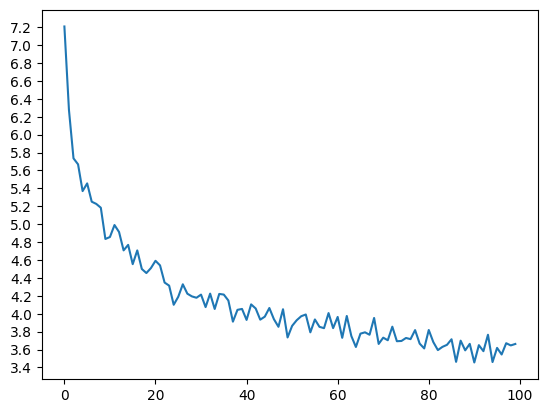

In [ ]:
hidden_size = 256
encoder1 = EncoderRNN(input_lang.n_words, hidden_size).to(device)
decoder1 = DecoderRNN(hidden_size, output_lang.n_words).to(device)

trainIters(encoder1, decoder1, 10000, print_every=1000)

1m 33s (- 14m 1s) (1000 10%) 5.9676
Dev Loss: 45.6888
6m 37s (- 26m 31s) (2000 20%) 5.8023
Dev Loss: 100.1218
14m 33s (- 33m 57s) (3000 30%) 5.5759
Dev Loss: 50.9805
19m 44s (- 29m 36s) (4000 40%) 5.4953
Dev Loss: 106.1509
27m 40s (- 27m 40s) (5000 50%) 5.5771
Dev Loss: 9.9605
30m 51s (- 20m 34s) (6000 60%) 5.3809
Dev Loss: 10.6138
34m 4s (- 14m 36s) (7000 70%) 5.3357
Dev Loss: 112.3253
41m 49s (- 10m 27s) (8000 80%) 5.2705
Dev Loss: 115.4608
49m 23s (- 5m 29s) (9000 90%) 5.3224
Dev Loss: 122.2263
57m 4s (- 0m 0s) (10000 100%) 5.4459
Dev Loss: 114.8507


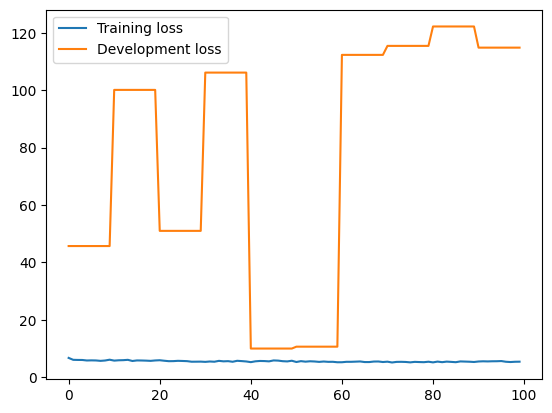

In [ ]:
hidden_size = 256
encoder1 = EncoderRNN(input_lang.n_words, hidden_size).to(device)
decoder1 = DecoderRNN(hidden_size, output_lang.n_words).to(device)

trainIters(encoder1, decoder1, 10000,dev_pairs=dev_pairs, print_every=1000)
torch.save(encoder1.state_dict(), 'encoder1.pth')
torch.save(decoder1.state_dict(), 'decoder1.pth')

# Save the trainIters function
import pickle
with open('trainIters.pkl', 'wb') as f:
    pickle.dump(trainIters, f)

In [ ]:
def remove_stop_words(text):
    stop_words = set(stopwords.words('english'))
    word_tokens = word_tokenize(text)
    filtered_text = ' '.join([word for word in word_tokens if word.lower() not in stop_words])
    return filtered_text
df3 = pd.read_csv("/content/drive/MyDrive/test.csv")
for x in range(len(df3['Recipe'])):
    if type(df3['Recipe'][x]) != str:
        df3['Recipe'][x] = ''
# Apply the function to the DataFrame columns
df3['Ingredients'] = df3['Ingredients'].apply(remove_stop_words)
df3['Recipe'] = df3['Recipe'].apply(remove_stop_words)

In [ ]:
with open("eng-fra3.txt", "w") as file:
    for index, row in df3.iterrows():
        file.write(f"{row['Recipe']}:::{row['Ingredients']}\n")

def readLangs(lang1, lang2, reverse=False, file_name='eng-fra3.txt'):
    print("Reading lines...")

    # Read the file and split into lines
    file_name = file_path + file_name
    lines = open(file_name, encoding='utf-8').\
        read().strip().split('\n')

    # Split every line into pairs and normalize
    pairs = [[normalizeString(s) for s in l.split(':::')] for l in lines]

    # Reverse pairs, make Lang instances
    if reverse:
        pairs = [list(reversed(p)) for p in pairs]
        input_lang = Lang(lang2)
        output_lang = Lang(lang1)
    else:
        input_lang = Lang(lang1)
        output_lang = Lang(lang2)

    return input_lang, output_lang, pairs

def filterPair(p):
    return len(p[0].split(' ')) < MAX_LENGTH and \
        len(p[1].split(' ')) < MAX_LENGTH

def filterPairs(pairs):
    return [pair for pair in pairs if filterPair(pair)]

def prepareData(lang1, lang2, reverse=False, file_name='eng-fra3.txt'):
    input_lang, output_lang, pairs = readLangs(lang1, lang2, reverse, file_name)
    print("Read %s sentence pairs" % len(pairs))
    pairs = filterPairs(pairs)
    print("Trimmed to %s sentence pairs" % len(pairs))
    print("Counting words...")
    for pair in pairs:
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])
    print("Counted words:")
    print(input_lang.name, input_lang.n_words)
    print(output_lang.name, output_lang.n_words)
    return input_lang, output_lang, pairs

def indexesFromSentence(lang, sentence):
    return [lang.word2index.get(word, UNK_token) for word in sentence.split(' ')]

def tensorFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long).view(-1, 1)

def tensorsFromPair(pair):
    input_tensor = tensorFromSentence(input_lang, pair[0])
    target_tensor = tensorFromSentence(output_lang, pair[1])
    return (input_tensor, target_tensor)

# Process test data
test_input_lang, test_output_lang, test_pairs = prepareData('eng', 'fra', True, 'eng-fra3.txt')
print(random.choice(test_pairs))


Reading lines...
Read 778 sentence pairs
Trimmed to 742 sentence pairs
Counting words...
Counted words:
fra 1849
eng 3207
[' oz bag frozen corn lb sharp cheddar cheese cn oz . chopped green chilis cloves garlic', ' jalapeno peppers cubanelle peppers onion splash tabasco shred cheese mix corn dump chilis mix . clean options lrb core seed peppers remove skin garlic rrb chop garlic peppers finely food processor slice onion fry garlic fresh peppers onion pan w little oil . saute minutes throw mix . mix put corningware .']


In [ ]:
def evaluate(encoder, decoder, sentence, max_length=MAX_LENGTH):
    with torch.no_grad():
        input_tensor = tensorFromSentence(input_lang, sentence).to(device)
        input_length = input_tensor.size()[0]
        encoder_hidden = encoder.initHidden()

        # Move each element of the encoder_hidden tuple to the device
        encoder_hidden = tuple(h.to(device) for h in encoder_hidden)

        encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

        for ei in range(input_length):
            encoder_output, encoder_hidden = encoder(input_tensor[ei], encoder_hidden)
            encoder_outputs[ei] += encoder_output[0, 0]

        decoder_input = torch.tensor([[SOS_token]], device=device)  # SOS
        decoder_hidden = encoder_hidden

        decoded_words = []
        for di in range(max_length):
            decoder_output, decoder_hidden = decoder(
                decoder_input, decoder_hidden)
            topv, topi = decoder_output.topk(1)
            if topi.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            else:
                decoded_words.append(output_lang.index2word[topi.item()])

            decoder_input = topi.squeeze().detach().to(device)

        return decoded_words


In [ ]:
import nltk
from nltk.translate.bleu_score import sentence_bleu, corpus_bleu
from tqdm import tqdm

def evaluate_bleu(encoder, decoder, test_pairs):
    references = []  # Stores reference sentences for each prediction
    hypotheses = []  # Stores predicted sentences

    for pair in tqdm(test_pairs):
        input_sentence = pair[0]
        target_sentence = pair[1]

        output_words = evaluate(encoder, decoder, input_sentence)
        output_sentence = ' '.join(output_words)

        # Removing <SOS> and <EOS> tokens from target_sentence
        target_sentence = target_sentence.split()
        if target_sentence[0] == "SOS":
            target_sentence = target_sentence[1:]
        if target_sentence[-1] == "EOS":
            target_sentence = target_sentence[:-1]

        references.append([target_sentence])
        hypotheses.append(output_words)

    bleu_score = corpus_bleu(references, hypotheses)
    return bleu_score

# Assuming you have test_pairs variable containing test data
encoder1 = encoder1.to(device)
decoder1 = decoder1.to(device)

bleu_score = evaluate_bleu(encoder1, decoder1, test_pairs)
print("BLEU-4 Score:", bleu_score)


100%|██████████| 742/742 [00:15<00:00, 47.72it/s]

BLEU-4 Score: 0.001473733991008767


In [ ]:
from nltk.translate.meteor_score import meteor_score
def evaluate_meteor(encoder, decoder, test_pairs):
    references = []  # Stores reference sentences for each prediction
    hypotheses = []  # Stores predicted sentences

    for pair in tqdm(test_pairs):
        input_sentence = pair[0]
        target_sentence = pair[1]

        output_words = evaluate(encoder, decoder, input_sentence)
        output_sentence = ' '.join(output_words)

        # Split reference sentence into tokens
        target_tokens = target_sentence.strip().split()

        references.append(target_tokens)
        hypotheses.append(output_sentence)

    meteor_avg = meteor_score(references, hypotheses)
    return meteor_avg

# Assuming you have test_pairs variable containing test data
meteor_score = evaluate_meteor(encoder1, decoder1, test_pairs)
print("METEOR Score:", meteor_score)



100%|██████████| 742/742 [00:19<00:00, 37.93it/s]


METEOR Score: 0.0


In [ ]:
def evaluate_accuracy(encoder, decoder, test_pairs):
    total_correct = 0
    total_items = 0

    for pair in tqdm(test_pairs):
        input_sentence = pair[0]
        target_sentence = pair[1]

        output_words = evaluate(encoder, decoder, input_sentence)
        output_sentence = ' '.join(output_words)

        # Tokenize target and output sentences for comparison
        target_tokens = target_sentence.strip().split()
        output_tokens = output_sentence.strip().split()

        # Calculate number of correctly predicted items
        correct_items = sum(1 for token in output_tokens if token in target_tokens)

        total_correct += correct_items
        total_items += len(target_tokens)

    avg_accuracy = (total_correct / total_items) * 100 if total_items > 0 else 0
    return avg_accuracy

# Assuming you have test_pairs variable containing test data
accuracy = evaluate_accuracy(encoder1, decoder1, test_pairs)
print("Average Accuracy (%):", accuracy)


100%|██████████| 742/742 [00:13<00:00, 53.40it/s]

Average Accuracy (%): 14.521298834022389


In [ ]:
def evaluate_extra_items(encoder, decoder, test_pairs):
    total_extra_items = 0
    total_sentences = len(test_pairs)

    for pair in tqdm(test_pairs):
        input_sentence = pair[0]
        target_sentence = pair[1]

        output_words = evaluate(encoder, decoder, input_sentence)
        output_sentence = ' '.join(output_words)

        # Tokenize target and output sentences for comparison
        target_tokens = set(target_sentence.strip().split())
        output_tokens = set(output_sentence.strip().split())

        # Calculate number of extra predicted items
        extra_items = len(output_tokens - target_tokens)

        total_extra_items += extra_items

    avg_extra_items = total_extra_items / total_sentences if total_sentences > 0 else 0
    return avg_extra_items

# Assuming you have test_pairs variable containing test data
avg_extra_items = evaluate_extra_items(encoder1, decoder1, test_pairs)
print("Average Extra Items:", avg_extra_items)


100%|██████████| 742/742 [00:14<00:00, 51.73it/s]

Average Extra Items: 3.6199460916442048


In [ ]:
evaluateRandomly(encoder1, decoder1)

>  c onion finely minced tb worchestershire sauce c garlic finely minced tb mustard tb tiger sauce
= blend together ingredients .
< heat . add remaining ingredients . <EOS>

>  c corn syrup c peanut butter c brown sugar c rice krispies
= mix corn syrup brown sugar peanut butter . cook stove low heat mixture bubbles add rice krispies mix well . put greased x pan press cooled icen chocolate icing .
< combine ingredients . add remaining ingredients . <EOS>

>  lb corned beef round water onions carrots parsnips poatatoes oz c cabbage
= cover meat cold water dutch oven bring boil drain . add water cover bring boil reduce heat low . cover . cook meat nearly tender lrb hours rrb . skimming much fat possible cooking water rrb add vegetables cook vegetables water drain trim meat . lrb minutes rrb . remove vegetables water drain trim fat meat .
< combine ingredients . add remaining ingredients . add remaining ingredients . add remaining ingredients . <EOS>

>  c flour ts ground cinnamon c powder